# 이미지 10-frame 품질 점검 EDA
클린 샘플 리스트를 기반으로 각 샘플의 10-frame 이미지 품질(순서, 밝기, 누락 여부)을 점검합니다.

## 1. 필요 라이브러리 임포트
이미지 품질 점검을 위해 pandas, numpy, matplotlib, opencv(cv2) 등 필요한 라이브러리를 임포트합니다.

In [41]:
# 1. 필요 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. 이미지 10-frame 데이터 불러오기
클린 샘플 리스트와 각 샘플의 10-frame 이미지 경로를 불러옵니다.

In [55]:
# 2. 이미지 10-frame 데이터 불러오기
clean_csv_path = '../EDA/train_clean.csv'
df_clean = pd.read_csv(clean_csv_path)

# 이미지 10-frame 폴더 경로 생성 함수 (예시)
def get_image_dir(cls, sample_id):
    return f"../data/train/raw/image/{cls}/{sample_id}"  # 실제 구조에 맞게 수정 필요

df_clean['image_dir'] = df_clean.apply(lambda row: get_image_dir(row['class'], row['sample_id']), axis=1)

def get_image_files(image_dir):
    if not os.path.exists(image_dir):
        return []
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    files.sort()  # 순서 보장
    return [os.path.join(image_dir, f) for f in files]

df_clean['image_files'] = df_clean['image_dir'].apply(get_image_files)
display(df_clean[['sample_id', 'class', 'image_dir', 'image_files']].head())

,sample_id,class,image_dir,image_files
0,02181_H_A_N_C1,N/N,../data/train/raw/image/N/N/02181_H_A_N_C1,[../data/train/raw/image/N/N/02181_H_A_N_C1/02...
1,02117_H_A_N_C6,N/N,../data/train/raw/image/N/N/02117_H_A_N_C6,[../data/train/raw/image/N/N/02117_H_A_N_C6/02...
2,02497_H_A_N_C5,N/N,../data/train/raw/image/N/N/02497_H_A_N_C5,[../data/train/raw/image/N/N/02497_H_A_N_C5/02...
3,02604_H_A_N_C2,N/N,../data/train/raw/image/N/N/02604_H_A_N_C2,[../data/train/raw/image/N/N/02604_H_A_N_C2/02...
4,00322_H_A_N_C3,N/N,../data/train/raw/image/N/N/00322_H_A_N_C3,[../data/train/raw/image/N/N/00322_H_A_N_C3/00...


# 데이터 품질 및 샘플 분포/편향 EDA
이 노트북에서는 데이터 구조, 샘플별 modality 매칭, class/카메라/배우/시나리오별 분포 및 편향을 분석합니다.

---
## 1. 필요 라이브러리 임포트

In [43]:
# 1. 필요 라이브러리 임포트
import os
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
from pprint import pprint

## 2. 데이터 파일 경로 지정 및 폴더 구조 탐색
데이터 폴더 경로를 지정하고, 하위 폴더 및 파일 구조를 탐색하는 함수를 구현합니다.

In [44]:
# 2. 데이터 파일 경로 지정 및 폴더 구조 탐색
BASE_DIR = Path("../data/train/raw")
modalities = ["image", "video", "sensor"]
class_tokens = ["N", "SY"]

def list_leaf_dirs_with_files(path, exts=None):
    leaf_dirs = []
    if not path.exists():
        print(f"[경고] 경로 없음: {path.resolve()}")
        return leaf_dirs
    for root, dirs, files in os.walk(path):
        dirs[:] = [d for d in dirs if not d.startswith('.')]
        files = [f for f in files if not f.startswith('.')]
        if exts is not None:
            files = [f for f in files if Path(f).suffix.lower() in exts]
        if files and not dirs:
            leaf_dirs.append((Path(root), files))
    return leaf_dirs

def detect_class_from_path(p: Path):
    label = None
    for part in p.parts:
        if part in class_tokens:
            label = part
    return label

exts_map = {
    "image": {".jpg", ".jpeg", ".png"},
    "video": {".mp4", ".avi", ".mov"},
    "sensor": {".csv"},
}

for m in modalities:
    base = BASE_DIR / m
    leaf_dirs = list_leaf_dirs_with_files(base, exts=exts_map.get(m))
    print(f"\n[{m}] leaf dirs count =", len(leaf_dirs))
    for leaf_dir, files in leaf_dirs[:3]:
        print(f"  샘플 폴더: {leaf_dir}, 파일 수: {len(files)}")


[image] leaf dirs count = 4128
  샘플 폴더: ../data/train/raw/image/N/N/00073_H_A_N_C8, 파일 수: 10
  샘플 폴더: ../data/train/raw/image/N/N/02604_H_A_N_C7, 파일 수: 10
  샘플 폴더: ../data/train/raw/image/N/N/02117_H_A_N_C3, 파일 수: 10

[video] leaf dirs count = 4128
  샘플 폴더: ../data/train/raw/video/N/N/00073_H_A_N_C8, 파일 수: 1
  샘플 폴더: ../data/train/raw/video/N/N/02604_H_A_N_C7, 파일 수: 1
  샘플 폴더: ../data/train/raw/video/N/N/02117_H_A_N_C3, 파일 수: 1

[sensor] leaf dirs count = 4128
  샘플 폴더: ../data/train/raw/sensor/N/N/00073_H_A_N_C8, 파일 수: 1
  샘플 폴더: ../data/train/raw/sensor/N/N/02604_H_A_N_C7, 파일 수: 1
  샘플 폴더: ../data/train/raw/sensor/N/N/02117_H_A_N_C3, 파일 수: 1

[sensor] leaf dirs count = 4128
  샘플 폴더: ../data/train/raw/sensor/N/N/00073_H_A_N_C8, 파일 수: 1
  샘플 폴더: ../data/train/raw/sensor/N/N/02604_H_A_N_C7, 파일 수: 1
  샘플 폴더: ../data/train/raw/sensor/N/N/02117_H_A_N_C3, 파일 수: 1


## 3. 샘플 센서 데이터프레임 로드 및 구조 확인
샘플 센서 데이터 파일을 pandas로 읽어와 데이터프레임의 head, shape, info를 출력합니다.

In [45]:
# 3. 샘플 센서 데이터프레임 로드 및 구조 확인
sample_sensor_path = '../data/train/raw/sensor/N/N/00002_H_A_N_C1/00002_H_A_N_C1.csv'
if os.path.exists(sample_sensor_path):
    df = pd.read_csv(sample_sensor_path)
    display(df.head())
    print('Shape:', df.shape)
    print(df.info())
else:
    print('샘플 센서 데이터 파일이 존재하지 않습니다.')

,Frame,Segment Acceleration_Pelvis x,Segment Acceleration_Pelvis y,Segment Acceleration_Pelvis z,Segment Acceleration_Head x,Segment Acceleration_Head y,Segment Acceleration_Head z,Segment Acceleration_Right Shoulder x,Segment Acceleration_Right Shoulder y,Segment Acceleration_Right Shoulder z,...,Sensor Magnetic Field_Right Upper Leg z,Sensor Magnetic Field_Right Lower Leg x,Sensor Magnetic Field_Right Lower Leg y,Sensor Magnetic Field_Right Lower Leg z,Sensor Magnetic Field_Left Upper Leg x,Sensor Magnetic Field_Left Upper Leg y,Sensor Magnetic Field_Left Upper Leg z,Sensor Magnetic Field_Left Lower Leg x,Sensor Magnetic Field_Left Lower Leg y,Sensor Magnetic Field_Left Lower Leg z
0,1,0.062617,-0.048870,-0.030044,-0.009252,0.012555,-0.098667,-0.020554,-0.030100,-0.074217,...,0.150635,0.725342,-0.080566,-0.254150,0.294434,0.478271,-0.062500,0.733154,-0.007080,-0.244873
1,2,0.036992,-0.001940,-0.083425,-0.017515,0.003481,-0.038076,-0.027028,-0.011421,-0.081610,...,0.146973,0.729004,-0.082520,-0.255127,0.296143,0.475586,-0.065186,0.738770,-0.006592,-0.247559
2,3,0.041693,-0.001583,-0.077451,-0.006037,0.021714,-0.032317,-0.022667,-0.048253,-0.005132,...,0.142334,0.728027,-0.070557,-0.260986,0.295410,0.489258,-0.069824,0.738037,0.006836,-0.254395
3,4,0.054005,-0.032725,-0.057625,-0.003767,-0.001741,-0.026501,-0.021888,-0.047693,-0.006688,...,0.148926,0.725586,-0.073242,-0.253174,0.293701,0.484619,-0.061768,0.734863,0.000244,-0.245605
4,5,0.040068,0.009601,-0.077571,-0.013896,0.032709,0.018194,-0.022562,-0.048942,-0.006695,...,0.148926,0.734375,-0.082275,-0.252930,0.302490,0.477051,-0.063477,0.741211,-0.007812,-0.243896


Shape: (600, 109)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Columns: 109 entries, Frame to Sensor Magnetic Field_Left Lower Leg z
dtypes: float64(108), int64(1)
memory usage: 511.1 KB
None


## 5. 파일 매칭 및 샘플별 파일 집계
raw 데이터의 modality별(이미지, 비디오, 센서)로 샘플별 파일 존재 여부를 탐색하고, class별 샘플 수를 집계합니다.

In [46]:
# 5. 파일 매칭 및 샘플별 파일 집계
result = defaultdict(lambda: defaultdict(set))
for m in modalities:
    base = BASE_DIR / m
    leaf_dirs = list_leaf_dirs_with_files(base, exts=exts_map.get(m))
    for leaf_dir, files in leaf_dirs:
        cls = detect_class_from_path(leaf_dir)
        if cls is None:
            continue
        sample_id = leaf_dir.name
        result[cls][m].add(sample_id)

for cls in class_tokens:
    print(f"\n=== 클래스: {cls} ===")
    for m in modalities:
        print(f"{m}: 샘플 수 = {len(result[cls][m])}")


=== 클래스: N ===
image: 샘플 수 = 2272
video: 샘플 수 = 2272
sensor: 샘플 수 = 2272

=== 클래스: SY ===
image: 샘플 수 = 1856
video: 샘플 수 = 1856
sensor: 샘플 수 = 1856


In [47]:
for cls in class_tokens:
    print(f"\n=== 클래스: {cls} ===")
    for m in modalities:
        print(f"{m}: 샘플 수 = {len(result[cls][m])}")
    intersection = result[cls]["image"] & result[cls]["video"] & result[cls]["sensor"]
    print(f"모든 modality 존재 샘플 수 = {len(intersection)}")
    print(f"교집합 샘플 리스트: {sorted(list(intersection))[:10]}")


=== 클래스: N ===
image: 샘플 수 = 2272
video: 샘플 수 = 2272
sensor: 샘플 수 = 2272
모든 modality 존재 샘플 수 = 2272
교집합 샘플 리스트: ['00002_H_A_N_C1', '00002_H_A_N_C2', '00002_H_A_N_C3', '00002_H_A_N_C4', '00002_H_A_N_C5', '00002_H_A_N_C6', '00002_H_A_N_C7', '00002_H_A_N_C8', '00006_H_A_N_C1', '00006_H_A_N_C2']

=== 클래스: SY ===
image: 샘플 수 = 1856
video: 샘플 수 = 1856
sensor: 샘플 수 = 1856
모든 modality 존재 샘플 수 = 1856
교집합 샘플 리스트: ['00004_H_A_SY_C1', '00004_H_A_SY_C2', '00004_H_A_SY_C3', '00004_H_A_SY_C4', '00004_H_A_SY_C5', '00004_H_A_SY_C6', '00004_H_A_SY_C7', '00004_H_A_SY_C8', '00008_H_A_SY_C1', '00008_H_A_SY_C2']


## 6. 클린 샘플 리스트 생성 및 저장
정상적으로 모든 modality가 존재하는 샘플만을 모아 DataFrame으로 만들고, csv로 저장합니다.

## 3. 이미지 순서 및 누락 여부 점검
각 샘플의 이미지가 10장 모두 존재하는지, 파일명/순서가 올바른지 점검합니다.

In [50]:
df_clean['image_files'] = df_clean['image_dir'].apply(get_image_files)

In [56]:


# 10장 모두 있는지, 파일명/순서가 올바른지 점검
def check_image_quality(image_files):
    result = {
        'num_images': len(image_files),
        'missing': len(image_files) != 10,
        'ordered': True
    }
    try:
        frame_nums = [int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]) for f in image_files]
        result['ordered'] = frame_nums == list(range(1, 11))
    except:
        result['ordered'] = False
    return result

quality_results = df_clean['image_files'].apply(check_image_quality)
df_quality = pd.DataFrame(list(quality_results))
display(df_quality.describe())
print(df_quality.value_counts())

,num_images
count,4128.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


num_images  missing  ordered
10          False    False      4128
Name: count, dtype: int64


## 4. 이미지 밝기 분석
각 이미지의 평균 밝기를 계산하여 품질을 점검합니다.

샘플 0 | sample_id: 02181_H_A_N_C1
image_dir: ../data/train/raw/image/N/N/02181_H_A_N_C1
image_files: ['../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I001.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I002.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I003.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I004.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I005.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I006.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I007.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I008.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I009.jpg', '../data/train/raw/image/N/N/02181_H_A_N_C1/02181_H_A_N_C1_I010.jpg']
첫 이미지 읽기 결과: 성공
첫 이미지 평균 밝기: 191.36385549286265
-
샘플 1 | sample_id: 02117_H_A_N_C6
image_dir: ../data/train/raw/image/N/N/02117_H_A_N_C6
image_files: ['../data/train/raw/image/N/N/02117_H_A_N_C6/0211

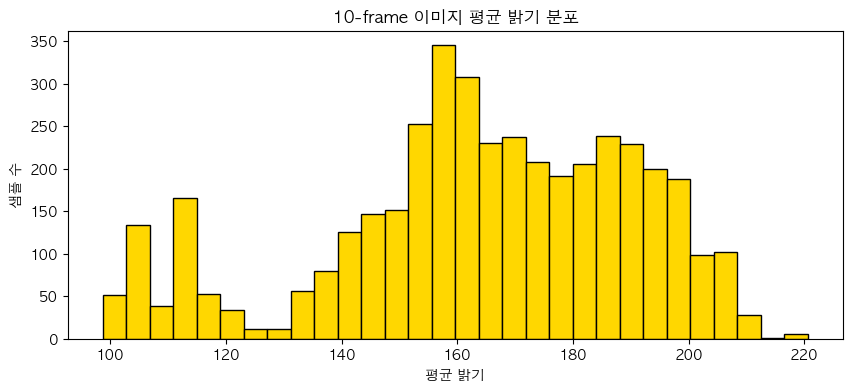

count    4128.000000
mean      164.016229
std        26.708253
min        98.761947
25%       150.675518
50%       165.413167
75%       184.820856
max       220.584132
Name: mean_brightness, dtype: float64


In [57]:
# 4. 이미지 밝기 분석 (디버깅 추가)

# 각 이미지의 평균 밝기 계산 및 경로/읽기 상태 출력
def calc_brightness(image_files):
    if len(image_files) == 0:
        print("[경고] 이미지 파일 리스트가 비어있음.")
        return np.nan
    brightness_list = []
    for f in image_files:
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness_list.append(np.mean(img))
        else:
            print(f"[경고] 이미지를 읽을 수 없음: {f}")
    if len(brightness_list) == 0:
        print("[경고] 모든 이미지가 읽히지 않음.")
        return np.nan
    return np.mean(brightness_list)

# 샘플별 이미지 파일 경로 및 밝기 디버깅 출력
for i, row in df_clean.head(5).iterrows():
    print(f"샘플 {i} | sample_id: {row['sample_id']}")
    print("image_dir:", row['image_dir'])
    print("image_files:", row['image_files'])
    if len(row['image_files']) > 0:
        test_img = cv2.imread(row['image_files'][0], cv2.IMREAD_GRAYSCALE)
        print("첫 이미지 읽기 결과:", "성공" if test_img is not None else "실패")
        if test_img is not None:
            print("첫 이미지 평균 밝기:", np.mean(test_img))
    print("-")

# 실제 밝기 계산
df_clean['mean_brightness'] = df_clean['image_files'].apply(calc_brightness)

plt.figure(figsize=(10,4))
plt.hist(df_clean['mean_brightness'].dropna(), bins=30, color='gold', edgecolor='black')
plt.title('10-frame 이미지 평균 밝기 분포')
plt.xlabel('평균 밝기')
plt.ylabel('샘플 수')
plt.show()

print(df_clean['mean_brightness'].describe())

## 주요 특징
- 중값 근처에 샘플이 집중
- 밝기 150~190 구간에 샘플이 가장 많음
- 대부분의 이미지가 적당한 밝기를 가짐
- 일부 샘플은 매우 어둡거나, 매우 밝은 경우도 있음
- 이상치(Outlier) 존재
- 밝기 100 이하, 210 이상 구간에 소수의 샘플 존재


## 결론 및 활용
- 대부분의 데이터는 적정 밝기(150~190)로 품질 양호
- 밝기 극단값(100 이하, 210 이상)은 품질 점검/필터링 대상으로 삼을 수 있음
- 밝기 편향이 있으므로, 모델 학습 시 밝기 증강/보정이 필요할 수 있음